# Gaussian processes

Another model class, where Gaussian manipulation is heavily used are Gaussian processes (GPs). Hence also here `GT` can excel.

*Disclaimer*: As for the state-space models, this is just a small example to show how `GT` can be used. It cannot compete with functionalities of specialized GP toolboxes like [GPFlow](https://www.gpflow.org/), or [GPJax](https://github.com/thomaspinder/GPJax).

**Definition**: *A Gaussian process is a collection of random variables, any Gaussian process finite number of which have a joint Gaussian distribution.* [\[Rasmussen & Williams, 2006\]](https://gaussianprocess.org/gpml/chapters/RW2.pdf)

Below we demonstrate, how a `GT` based suite can implement very efficiently GP regression for exact and sparse [\[Tisias, 2009\]](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf). We just defined prior, and likelihood objects based on the Gaussian operations defined previously. The objectives (marginal likelihood for exact and evidence lower bound for sparse GPs) can be well expressed in Gaussian integrals, and then used for hyperparameter optimization.

In [17]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from gaussian_toolbox.gaussian_process import kernel, prior, likelihood, model
from jax import numpy as jnp

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exact GP: 1D Examples

First we generate some simple 1D dataset.

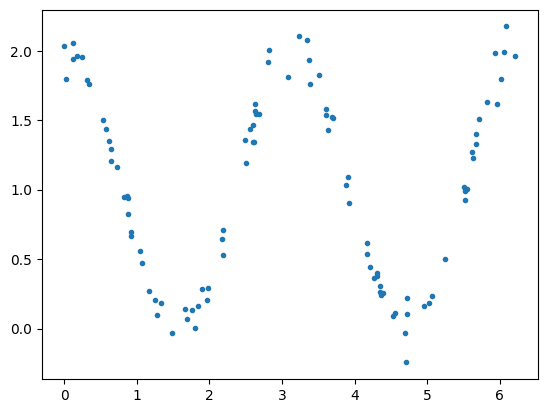

In [18]:
# Create data
num_points = 100
sigma_y = .1
x = jnp.array(np.sort(2 * np.pi * np.random.rand(num_points, 1), axis=0))
x_star = jnp.array([jnp.arange(0, 2 * jnp.pi, .1)]).T
y = jnp.array(np.cos(2 * x) + sigma_y * np.random.randn(num_points, 1)) + 1.
y = y.flatten()
plt.plot(x , y, '.')
plt.show()


### Exact GP regression

We create a GP prior with corresponding kernel, and likelihood. This two are combined into a GP regression model, that then can be inferred (with learning the hyperparameters).

In [19]:
# Create model and do inference
k_func = kernel.Matern32()
gp_prior = prior.GP_Prior(k_func)
lk = likelihood.GaussianLikelihood()
gp_model = model.GPRegressionModel(gp_prior, lk)
gp_model.infer(x, y)

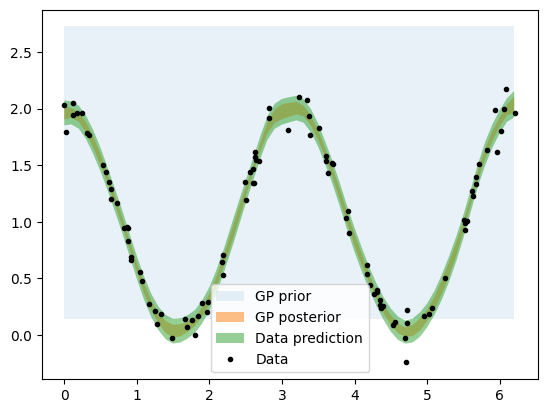

In [20]:
# Predictions
prior_x = gp_prior.get_density(x_star)
predictive_gp = gp_model.predict_gp(x_star, True)
predictive_data = gp_model.predict_data(x_star, True)

plt.fill_between(x_star[:,0], prior_x.mu[0] - prior_x.Sigma[0].diagonal(), prior_x.mu[0] + prior_x.Sigma[0].diagonal(), alpha=.1, label="GP prior")
plt.fill_between(x_star[:,0], predictive_gp.mu[:,0] - np.sqrt(predictive_gp.Sigma[:,0,0]), predictive_gp .mu[:,0] + np.sqrt(predictive_gp.Sigma[:,0,0]), alpha=.5, label="GP posterior")
plt.fill_between(x_star[:,0], predictive_data.mu[:,0] - np.sqrt(predictive_data.Sigma[:,0,0]), predictive_data.mu[:,0] + np.sqrt(predictive_data.Sigma[:,0,0]), alpha=.5, label="Data prediction")
plt.plot(x , y, 'k.', label="Data")
plt.legend()
plt.show()

### Sparse GP regression

Same we can do for sparse GPs. The difference to exact GPs is that we work with a *sparse likelihood* that is defined as follows

$$
\ln p(y\vert g_u) = \mathbb{E}_{g\vert g_u}\left[\ln p(y\vert g)\right],
$$
where the expectations is over the conditional prior $p(g\vert g_u)$, where $g_u$ are the function values at a set of so called *inducing points* $X_u$.

In [21]:
# Create model and do inference
num_inducing_points = 20
k_func = kernel.Matern32()
Xu = 2 * jnp.pi * jnp.array(np.random.rand(num_inducing_points,1))
sgp_prior = prior.SparseGP_Prior(k_func, Xu, optimize_Xu=True)
lk = likelihood.GaussianLikelihood()
sgp_model = model.SGPRegressionModel(sgp_prior, lk)
sgp_model.infer(x, y)

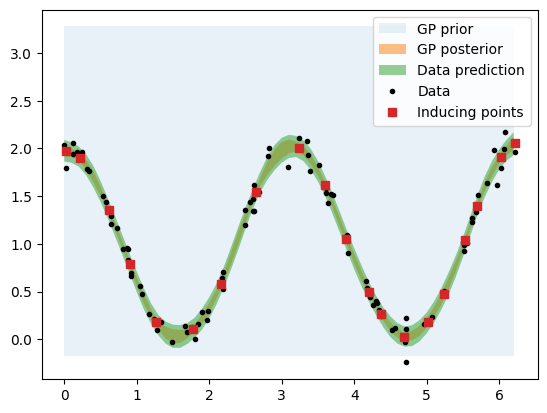

In [22]:
# Predictions
prior_x = sgp_prior.get_density(x_star)
predictive_gp = sgp_model.predict_gp(x_star, True)
predictive_data = sgp_model.predict_data(x_star, True)

plt.fill_between(x_star[:,0], prior_x.mu[0] - prior_x.Sigma[0].diagonal(), prior_x.mu[0] + prior_x.Sigma[0].diagonal(), alpha=.1, label="GP prior")
plt.fill_between(x_star[:,0], predictive_gp.mu[:,0] - np.sqrt(predictive_gp.Sigma[:,0,0]), predictive_gp.mu[:,0] + np.sqrt(predictive_gp.Sigma[:,0,0]), alpha=.5, label="GP posterior")
plt.fill_between(x_star[:,0], predictive_data.mu[:,0] - np.sqrt(predictive_data.Sigma[:,0,0]), predictive_data.mu[:,0] + np.sqrt(predictive_data.Sigma[:,0,0]), alpha=.5, label="Data prediction")
plt.plot(x , y, 'k.', label="Data")
plt.plot(sgp_model.prior.Xu[:,0], sgp_model.posterior_density.mu[0], 'C3s', label="Inducing points")
plt.legend()
plt.show()

# 2D Example

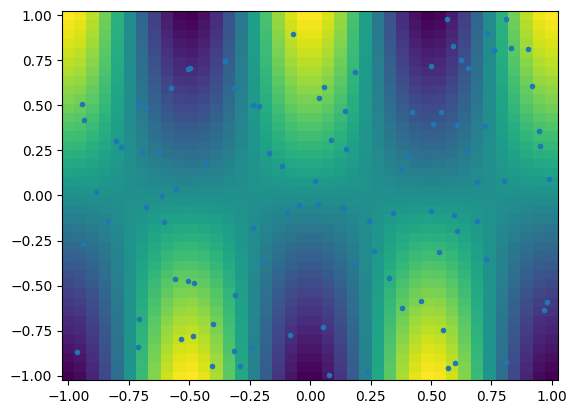

In [23]:
limits = [[-1,1], [-1, 1]]
num_points_star = 40
num_points = 100
sigma_y = .1
x_range, y_range = jnp.linspace(limits[0][0], limits[0][1], num_points_star), jnp.linspace(limits[1][0], limits[1][1], num_points_star)
x_grid, y_grid = np.meshgrid(x_range, y_range)
x_star = jnp.vstack([x_grid.flatten(), y_grid.flatten()]).T
true_func = lambda x: jnp.cos(2 * np.pi * x[:,0]) * jnp.sin(x[:,1])
x = np.random.rand(num_points, 2)
x[:,0] = (limits[0][1] - limits[0][0]) * x[:,0] + limits[0][0]
x[:,1] = (limits[1][1] - limits[1][0]) * x[:,1] + limits[1][0]
x = jnp.array(x)
y = true_func(x) + sigma_y * np.random.randn(num_points)
plt.pcolor(x_range, y_range, true_func(x_star).reshape((num_points_star, num_points_star)))
plt.plot(x[:,0], x[:,1], '.')

### Exact GP regression

In [24]:
k_func = kernel.Matern32()
gp_prior = prior.GP_Prior(k_func)
lk = likelihood.GaussianLikelihood()
gp_model = model.GPRegressionModel(gp_prior, lk)
gp_model.infer(x, y)

In [25]:
prior_x = gp_prior.get_density(x_star)
predictive_gp = gp_model.predict_gp(x_star, True)
predictive_data = gp_model.predict_data(x_star, True)

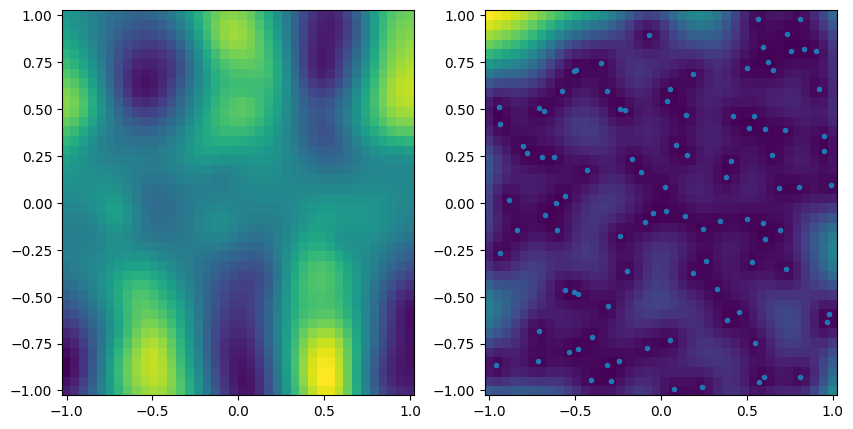

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pcolor(x_range, y_range, predictive_data.mu[:,0].reshape((num_points_star, num_points_star)))
plt.subplot(122)
plt.pcolor(x_range, y_range, predictive_data.Sigma[:,0,0].reshape((num_points_star, num_points_star)))
plt.plot(x[:,0], x[:,1], '.')

### Sparse GP regression

In [27]:
num_inducing_points = 20
Xu = np.random.rand(num_inducing_points,2)
Xu[:,0] = (limits[0][1] - limits[0][0]) * Xu[:,0] + limits[0][0]
Xu[:,1] = (limits[1][1] - limits[1][0]) * Xu[:,1] + limits[1][0]
Xu = jnp.array(Xu)
k_func = kernel.RBF()
sgp_prior = prior.SparseGP_Prior(k_func, Xu, optimize_Xu=True)
lk = likelihood.GaussianLikelihood()
sgp_model = model.SGPRegressionModel(sgp_prior, lk)
sgp_model.infer(x, y, True)

In [28]:
prior_x = sgp_prior.get_density(x_star)
predictive_gp = sgp_model.predict_gp(x_star, True)
predictive_data = sgp_model.predict_data(x_star, True)

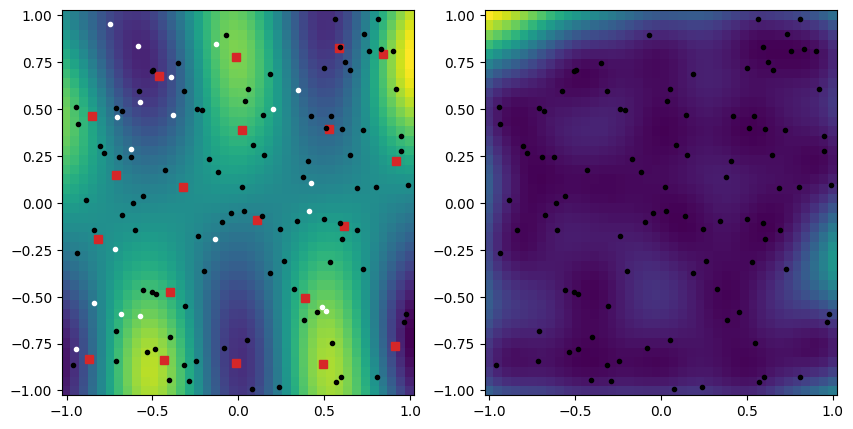

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pcolor(x_range, y_range, predictive_data.mu[:,0].reshape((num_points_star, num_points_star)))
plt.plot(Xu[:,0], Xu[:,1], 'w.')
plt.plot(sgp_model.prior.Xu[:,0], sgp_model.prior.Xu[:,1], 'C3s')
plt.plot(x[:,0], x[:,1], 'k.')
plt.subplot(122)
plt.pcolor(x_range, y_range, predictive_data.Sigma[:,0,0].reshape((num_points_star, num_points_star)))
plt.plot(x[:,0], x[:,1], 'k.')
plt.show()